In [2]:
import os
import pickle
import multiprocessing as mp
import math
import pandas as pd

In [3]:

base_paths = [
    '/home/combined_everything_FL/run_data/d_snn_atks_defs_surrs',
    '/home/combined_everything_FL/run_data/d_ipm_increased_scale',
    '/home/combined_everything_FL/run_data/d_ann_atks_defs',
    '/home/combined_everything_FL/run_data/d_decrease_gaussian_std'
]
file_paths = [os.path.join(base_path, f) for base_path in base_paths for f in os.listdir(base_path) if f.startswith('exp_')]
class ExpRecord:
    pass

In [4]:
exps = []
for path in file_paths:
    exp = pickle.load(open(path, 'rb'))
    if exp.attack['type'] == 'IPM' and exp.attack['params']['scale'] == 0.1:
        continue
    if exp.attack['type'] == 'GaussRandom' and ('std' not in exp.attack['params'] or exp.attack['params']['std'] != 1.0):
        continue
    # if exp.attack['type'] == 'GaussRandom':
    #     print(exp.attack)
    exps.append(exp)
print(len(exps))

1032


In [5]:
data = []
for exp in exps:
    if len(getattr(exp, 'test_accs', [])) == 0 or getattr(exp, 'checkpointed_epoch', None) != 2000:
        continue
    # Extract the attributes from each experiment
    row = {
        'model': exp.model,
        'data': exp.dataset,
        'surr': exp.snn_hyperparams['surrogate']['type'][:-4] if exp.model.startswith('snn') else 'None',
        'atk': str(exp.attack['type']),
        'def': exp.aggregator['type'],
        'best_acc': max([i[1] for i in exp.test_accs]),
    }

    if row['atk'] == 'SignFlip': 
        row['atk'] = 'S.F.'
    elif row['atk'] == 'LabelFlip': 
        row['atk'] = 'L.F.'
    elif row['atk'] == 'GaussRandom': 
        row['atk'] = 'G.R.'

    if row['def'] == 'SignGuard': 
        row['def'] = 'S.G.'
    elif row['def'] == 'CenterClipping':
        row['def'] = 'C.C.'
    elif row['def'] == 'NormClipping':
        row['def'] = 'N.C.'

    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

# Display the first few rows
df.head()

,model,data,surr,atk,def,best_acc
0,snn_vgg9,CIFAR10,Rectangle,MinMax,DnC,0.7202
1,snn_vgg9,CIFAR100,Rectangle,MinMax,RFA,0.0191
2,snn_vgg9,CIFAR10,Gaussian,L.F.,Mean,0.4522
3,snn_vgg9,CIFAR100,Triangle,MinMax,DnC,0.4641
4,snn_vgg9,CIFAR10,Rectangle,MinMax,RFA,0.1146


In [6]:
print(df['surr'].unique())
print(df['model'].unique())
print(df['data'].unique())
print(df['atk'].unique())
print(df['def'].unique())

['Rectangle' 'Gaussian' 'Triangle' 'FastSigmoid' 'Quadratic' 'None']
['snn_vgg9' 'snn_fc' 'ann_vgg9' 'ann_fc']
['CIFAR10' 'CIFAR100' 'MNIST' 'FMNIST']
['MinMax' 'L.F.' 'Mimic' 'S.F.' 'Fang' 'None' 'IPM' 'G.R.']
['DnC' 'RFA' 'Mean' 'S.G.' 'C.C.' 'N.C.']


## 3D plot for effectiveness of defenses in different surrogate gradients

In [7]:
snn = df[(df['model'].str.startswith('snn'))]

In [8]:
a = snn
# Not attacked
b = a[(a['atk'] == 'None') & (a['def'] == 'Mean')].rename(columns={'best_acc': 'baseline'})
# Attacked without defense
c = a[(a['atk'] != 'None') & (a['def'] == 'Mean')].rename(columns={'best_acc': 'atked'})
# Attacked with defense
d = a[(a['atk'] != 'None') & (a['def'] != 'Mean')].rename(columns={'best_acc': 'defed'}) 
e = pd.merge(c, b.drop('atk', axis=1), 'left', ['model', 'data', 'surr', 'def'],)
f = pd.merge(d, e, 'left', ['model', 'data', 'surr', 'atk'])
f['score'] = (f['defed'] - f['atked'])/(f['baseline'] - f['atked'])
# f[['model','data','surr','atk','def_x','score']].sort_values(['model', 'data', 'atk', 'def_x', 'surr']).to_csv('def_eff.csv')

In [9]:
f = f[['model','data','surr','atk','def_x','score']].sort_values(['model', 'data', 'atk', 'def_x', 'surr'])

/tmp/ipykernel_3566009/2067601555.py:103: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


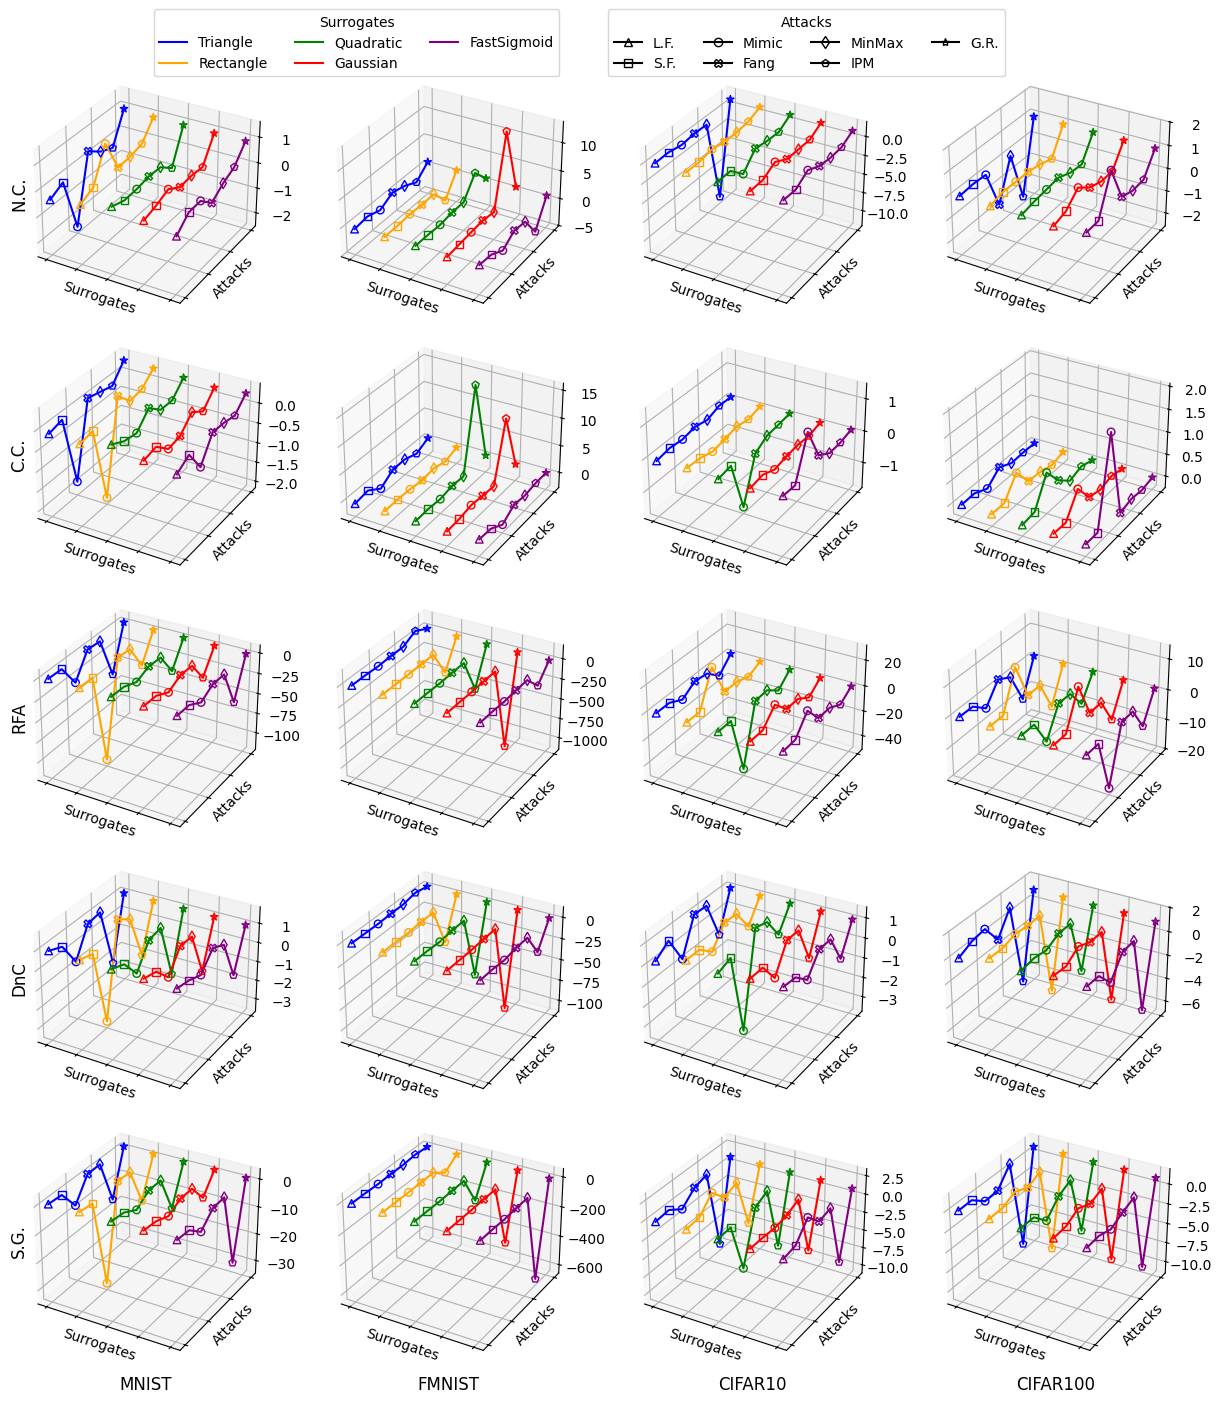

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 17))

plt.subplots_adjust(hspace=0)

surrs = ['Triangle','Rectangle','Quadratic','Gaussian','FastSigmoid']
surr_colors = [
    'blue',
    'orange', 
    'green',
    'red',
    'purple'
]
atk_marker_styles = [
    '^',
    's',
    'o',
    'X',
    'd',
    'p',
    '*'
]
stt = lambda s: surrs.index(s)
atks = ['L.F.', 'S.F.', 'Mimic', 'Fang', 'MinMax', 'IPM', 'G.R.']
att = lambda a: atks.index(a)
    
i = 1
for def_x in ['N.C.', 'C.C.', 'RFA', 'DnC', 'S.G.']:
    for dataset in ['MNIST', 'FMNIST', 'CIFAR10', 'CIFAR100']:
        ax = fig.add_subplot(5, 4, i, projection='3d')
        g = f[(f['def_x']==def_x) & (f['data'] == dataset)]
        for surr in surrs:
            x, y, z = [], [], []
            for atk in atks:
                a, b, c = stt(surr), att(atk), g[(g['surr'] == surr) & (g['atk'] == atk)]['score'].item()
                x.append(a)
                y.append(b)
                z.append(c)
                ax.scatter(a, b, c, 
                           marker=atk_marker_styles[att(atk)],
                        #    marker='X',
                           color=surr_colors[stt(surr)], 
                           s=30, 
                           facecolors='none'
                           )

            ax.plot(x, y, z, label=surr, color=surr_colors[stt(surr)])
                
        # ax.set_yticks(list(range(len(atks))))
        # ax.set_yticklabels(atks)
        # ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.set_yticks(list(range(len(atks))))
        # ax.set_yticklabels(atks)
        ax.set_xlabel('Surrogates', labelpad=-12)
        ax.set_ylabel('Attacks', labelpad=-12)
        # ax.set_zlabel('Score')
        # ax.legend()
        if i >= 17:
            # ax.set_title(dataset, pad=-200, loc='center')
            ax.text2D(0.5, -0.07, dataset, transform=ax.transAxes, fontsize=12, va='center', ha='center')

        if i % 4 == 1:
            # ax.text(-1.5, 0, 0, def_x, rotation=90, fontsize=12, va='center', ha='center')
            
            ax.text2D(0, 0.5, def_x, transform=ax.transAxes, rotation=90, fontsize=12, va='center', ha='center')

        i += 1

import matplotlib.lines as mlines
surr_legend_handles = [
    mlines.Line2D([], [], color=surr_color, 
                        #   marker='$?$',
                        #   markersize=10
                          )
    for surr_color in surr_colors
]

atk_legend_handles = [
    mlines.Line2D([], [], color='black', 
                          marker=marker,
                          markersize=6,
                          markerfacecolor='none'
                          )
    for marker in atk_marker_styles
]

fig.legend(surr_legend_handles, surrs, 
           loc='upper center', 
           bbox_to_anchor=(0.35, 0.915),
           ncol=3,
           title='Surrogates')

fig.legend(atk_legend_handles, atks, 
           loc='upper center', 
           bbox_to_anchor=(0.65, 0.915),
           ncol=4, 
           title='Attacks')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3566009/2744934351.py:103: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


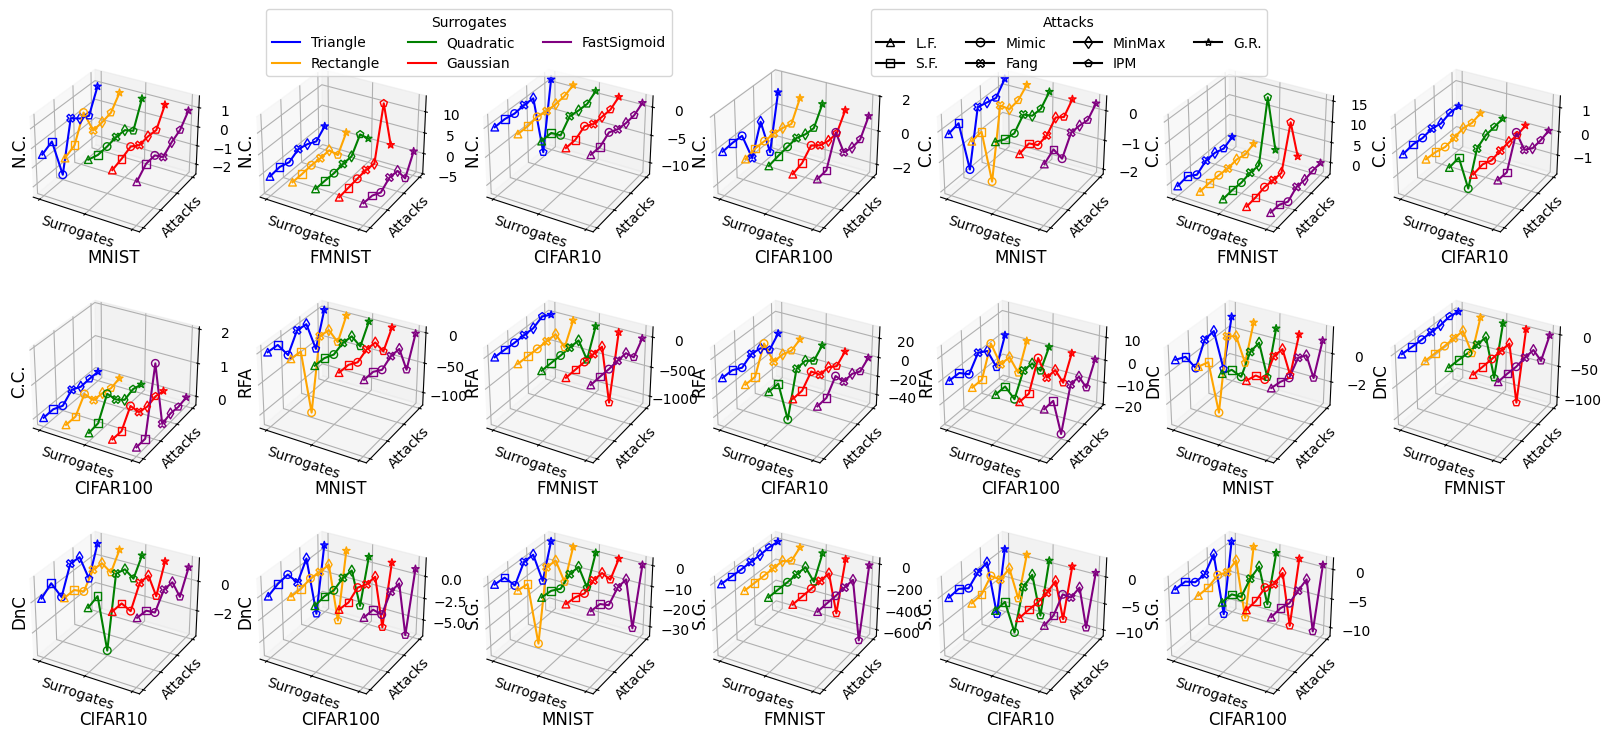

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 9))

plt.subplots_adjust(hspace=0)

surrs = ['Triangle','Rectangle','Quadratic','Gaussian','FastSigmoid']
surr_colors = [
    'blue',
    'orange', 
    'green',
    'red',
    'purple'
]
atk_marker_styles = [
    '^',
    's',
    'o',
    'X',
    'd',
    'p',
    '*'
]
stt = lambda s: surrs.index(s)
atks = ['L.F.', 'S.F.', 'Mimic', 'Fang', 'MinMax', 'IPM', 'G.R.']
att = lambda a: atks.index(a)
    
i = 1
for def_x in ['N.C.', 'C.C.', 'RFA', 'DnC', 'S.G.']:
    for dataset in ['MNIST', 'FMNIST', 'CIFAR10', 'CIFAR100']:
        ax = fig.add_subplot(3, 7, i, projection='3d')
        g = f[(f['def_x']==def_x) & (f['data'] == dataset)]
        for surr in surrs:
            x, y, z = [], [], []
            for atk in atks:
                a, b, c = stt(surr), att(atk), g[(g['surr'] == surr) & (g['atk'] == atk)]['score'].item()
                x.append(a)
                y.append(b)
                z.append(c)
                ax.scatter(a, b, c, 
                           marker=atk_marker_styles[att(atk)],
                        #    marker='X',
                           color=surr_colors[stt(surr)], 
                           s=30, 
                           facecolors='none'
                           )

            ax.plot(x, y, z, label=surr, color=surr_colors[stt(surr)])
                
        # ax.set_yticks(list(range(len(atks))))
        # ax.set_yticklabels(atks)
        # ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.set_yticks(list(range(len(atks))))
        # ax.set_yticklabels(atks)
        ax.set_xlabel('Surrogates', labelpad=-12)
        ax.set_ylabel('Attacks', labelpad=-12)
        # ax.set_zlabel('Score')
        # ax.legend()
        # if i >= 17:
        # ax.set_title(dataset, pad=-200, loc='center')
        ax.text2D(0.5, -0.07, dataset, transform=ax.transAxes, fontsize=12, va='center', ha='center')

        # if i % 4 == 1:
        # ax.text(-1.5, 0, 0, def_x, rotation=90, fontsize=12, va='center', ha='center')
            
        ax.text2D(0, 0.5, def_x, transform=ax.transAxes, rotation=90, fontsize=12, va='center', ha='center')

        i += 1

import matplotlib.lines as mlines
surr_legend_handles = [
    mlines.Line2D([], [], color=surr_color, 
                        #   marker='$?$',
                        #   markersize=10
                          )
    for surr_color in surr_colors
]

atk_legend_handles = [
    mlines.Line2D([], [], color='black', 
                          marker=marker,
                          markersize=6,
                          markerfacecolor='none'
                          )
    for marker in atk_marker_styles
]

fig.legend(surr_legend_handles, surrs, 
           loc='upper center', 
           bbox_to_anchor=(0.35, 0.915),
           ncol=3,
           title='Surrogates')

fig.legend(atk_legend_handles, atks, 
           loc='upper center', 
           bbox_to_anchor=(0.65, 0.915),
           ncol=4, 
           title='Attacks')

plt.tight_layout()
plt.show()